In [1]:
# notebook to evaluate the information retrieval results from an external system (i.e. not pyterrier)
import pyterrier as pt
if not pt.started():
    pt.init()


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [2]:

import xml.etree.ElementTree as ET
import pandas as pd

def load_topics(path):
    with open(path) as f:
        root = ET.fromstring(f.read())
    topic_dict = {}
    for topic in root.findall("topic"):
        topic_id = topic.findtext("id")
        topic_query = topic.findtext("query")
        if topic_id and topic_query:
            topic_dict[topic_id] = topic_query.strip().lower()
    topics = pd.DataFrame(topic_dict.items(), columns=["qid", "query"]) 
    topics["query"] = topics["query"].str.replace(r'\W+', ' ', regex=True)
    return topics

In [3]:
topics = load_topics("../data/topics/topics.txt")
qrels = pt.io.read_qrels("../data/assessments/qrels.txt") # type: ignore
qcred = pt.io.read_qrels("../data/assessments/qcredibility.txt") # type: ignore
qread = pt.io.read_qrels("../data/assessments/qreadability.txt") # type: ignore

all_qs = [("qrels", qrels), ("qcred", qcred), ("qread", qread)]

In [17]:
qrels.head()

,qid,docno,label
0,1,a6195d99-f7d7-43ec-907c-435cb7a62ee7,2
1,1,80fd9af1-c9b6-4d82-b62a-fe16d5b9d76f,1
2,1,4a8c5d85-b2d0-43bc-83f4-c1acfe0b3481,2
3,1,22990a4b-6a9f-4e00-9e72-aef0fbee202b,0
4,1,fd6ddab2-e4d9-4151-9972-256f5be6eb21,1


In [15]:
all_passages = pd.read_csv("../data/Webdoc/txt.tsv", sep="\t")

In [16]:
all_passages.head()

,docid,text
0,44f906a1-f818-4d48-a3fb-1673ebdeff13,Skip to main content Patient Care and Safety D...
1,334ed241-6337-41ce-884c-2755648e14ea,Skip to main content Patient Care and Safety D...
2,391b9de2-26dc-4187-b7ea-461153352e12,Skip to main content Patient Care and Safety D...
3,461b6eb2-2b79-4fec-bf6b-63e302a093d9,Skip to main content Patient Care and Safety D...
4,4e151d9e-a3fc-4e21-b5db-7b8ad4ea9d23,Skip to main content Patient Care and Safety D...


In [38]:
qrels_in_passages = qrels.merge(all_passages, left_on="docno", right_on="docid", how="inner")
# count the number of documents per query and return new dataframe
number_if_documents_per_query = qrels_in_passages.groupby("qid", as_index=False).count()[["qid", "docno"]]

In [5]:
import pyterrier as pt

def run_experiment(pipeline, simple_name, topics, qrels, eval_metrics=["map", "bpref", "ndcg_cut_10"]):
    experiments = []
    for name, q in qrels:
        # change pipeline name to include the name of the query

        exp = pt.Experiment([pipeline], topics, q, eval_metrics, names=[name + '_' + simple_name], perquery=True)
        experiments.append(exp)
    return pd.concat(experiments, axis=0)

In [6]:
# load results without index
simple_name = "colbert-pubmed-bert-rankings_at_10"
retrieval = pd.read_csv(f"rankings/{simple_name}.csv")

In [7]:

results = run_experiment(retrieval[retrieval['rank'] < 250],simple_name, topics, all_qs, ["map", "bpref", "ndcg_cut_10"])
results.to_csv("results/" + simple_name + "_results_perquery.csv")

/home/jonas/miniconda3/envs/faiss/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/jonas/miniconda3/envs/faiss/lib/python3.8/site-packages/pyterrier/pipelines.py:107: UserWarning: 5 topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.
  warn(f'{backfill_count} topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.')
/home/jonas/miniconda3/envs/faiss/lib/python3.8/site-packages/pyterrier/pipelines.py:107: UserWarning: 5 topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.
  warn(f'{backfill_count} topic(s) not found in qrels. Scores for these topics are given as NaN and should not contribute to averages.')
/home/jonas/miniconda3/en

In [46]:
results.dtypes

Unnamed: 0      int64
name           object
qid             int64
measure        object
value         float64
dtype: object

[Text(0.5, 0, 'Query ID (number of evaluated documents)'),
 Text(0, 0.5, 'ndcg@10')]

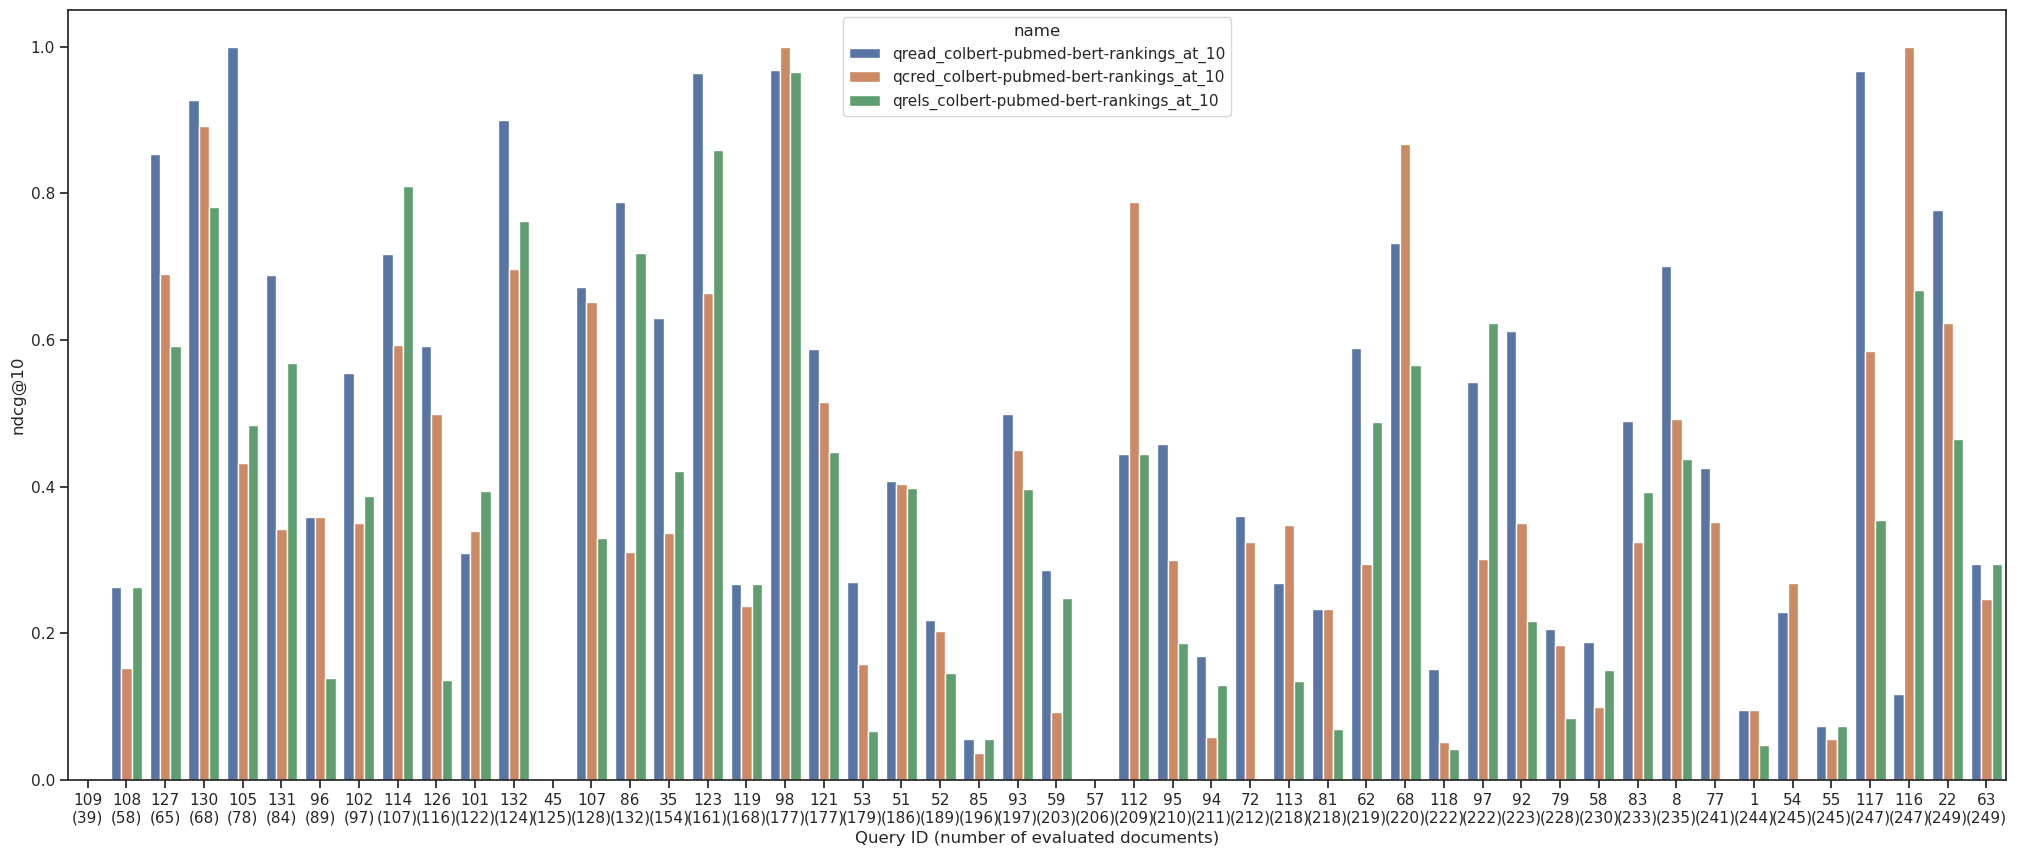

In [57]:
# visualize ndcg@10 for each query
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
# increase plot size
plt.rcParams['figure.figsize'] = [25, 10]
sns.set_style("ticks")

results = pd.read_csv("results/" + simple_name + "_results_perquery.csv")
results = results[results["measure"] == "ndcg_cut_10"]

results["qid"] = results["qid"].astype(str)
# add number of documents per query to qid
results = results.merge(number_if_documents_per_query, on="qid")

results = results.sort_values(by="docno", ascending=True)

results['qid_label'] = results['qid'] + "\n(" + results['docno'].astype(str) + ")"
# plot all ndcg@10 values for each query and for each score in  barplots
# add x-axis label
p = sns.barplot(x="qid_label", y="value", hue="name", data=results)
p.set(xlabel='Query ID (number of evaluated documents)', ylabel='ndcg@10')

In [49]:
results.head()

,Unnamed: 0,name,qid,measure,value,docno
0,2,qrels_colbert-pubmed-bert-rankings_at_10,1,ndcg_cut_10,0.047394,244
1,2,qcred_colbert-pubmed-bert-rankings_at_10,1,ndcg_cut_10,0.094788,244
2,2,qread_colbert-pubmed-bert-rankings_at_10,1,ndcg_cut_10,0.094788,244
3,92,qrels_colbert-pubmed-bert-rankings_at_10,101,ndcg_cut_10,0.393936,122
4,92,qcred_colbert-pubmed-bert-rankings_at_10,101,ndcg_cut_10,0.338913,122
